## Retrieving the Best Forecast from THREDDS

In [11]:
import xarray as xr

url = 'http://tds.ioos.us/thredds/dodsC/ioos/ofs/dbofs/forecast/regulargrid/DBOFS_Forecast_Regulargrid_best.ncd'

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:      (Depth: 21, ny: 487, nx: 529, ocean_time: 1, time: 821)
Coordinates:
  * Depth        (Depth) float64 0.0 2.0 4.0 6.0 8.0 ... 80.0 90.0 100.0 125.0
    Latitude     (ny, nx) float64 ...
    Longitude    (ny, nx) float64 ...
  * ocean_time   (ocean_time) datetime64[ns] 2023-06-27T15:00:00
  * time         (time) datetime64[ns] 2023-05-26T07:00:00 ... 2023-06-29T12:...
    time_run     (time) datetime64[ns] ...
Dimensions without coordinates: ny, nx
Data variables:
    time_offset  (time) datetime64[ns] ...
    h            (ny, nx) float64 ...
    mask         (ny, nx) float64 ...
    zeta         (time, ny, nx) float32 ...
    zetatomllw   (time, ny, nx) float32 ...
    u_eastward   (time, Depth, ny, nx) float32 ...
    v_northward  (time, Depth, ny, nx) float32 ...
    temp         (time, Depth, ny, nx) float32 ...
    salt         (time, Depth, ny, nx) float32 ...
Attributes: (12/78)
    file:                            nos.dbofs.fields.forecast.20230626.t12z_...
    format:                          netCDF-4/HDF5 file
    Conventions:                     CF-1.4, ACDD-1.3, IOOS-1.2
    type:                            ROMS/TOMS history file
    title:                           Delaware Bay Operational Forecast System...
    var_info:                        varinfo.yaml
    ...                              ...
    featureType:                     GRID
    cdm_data_type:                   GRID
    processing_level:                forecast_model
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    location:                        Proto fmrc:DBOFS_Forecast_Regulargrid
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

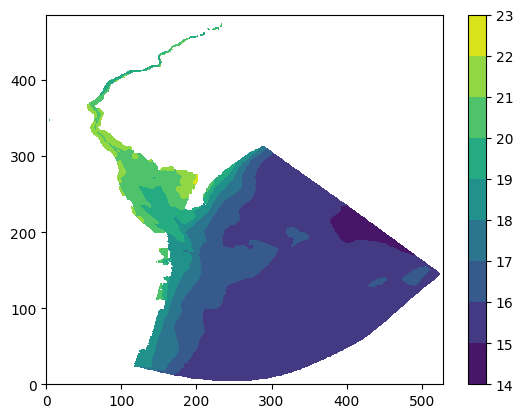

In [7]:
import matplotlib.pyplot as plt

plt.contourf(ds['temp'][0,0,:])
plt.colorbar()

## Best Forecast Kerchunk

We are virtually aggregating the DBOFS data in the zarr file: `s3://nextgen-dmac/nos/nos.dbofs.fields.best.nc.zarr`

In [1]:
import xarray as xr
import fsspec

url = 's3://nextgen-dmac/nos/nos.dbofs.fields.best.nc.zarr'

fs = fsspec.filesystem("reference", fo=url, 
                       remote_protocol='s3', target_options={'anon':True, 'use_ssl': False}, remote_options={'anon':True, 'use_ssl': False}, anon=True)
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False))
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 805, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lon_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2023-05-27T14:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/79)
    Akk_bak        (ocean_time) float64 ...
    Akp_bak        (ocean_time) float64 ...
    Akt_bak        (ocean_time, tracer) float64 ...
    Akv_bak        (ocean_time) float64 ...
    Cs_r           (ocean_time, s_rho) float64 ...
    Cs_w           (ocean_time, s_w) float64 ...
    ...             ...
    theta_s        (ocean_time) float64 ...
    u              (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v              (ocean_time, s_rho, eta_v, xi_v) float32 ...
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    xl             (ocean_time) float64 ...
    zeta           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230528.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

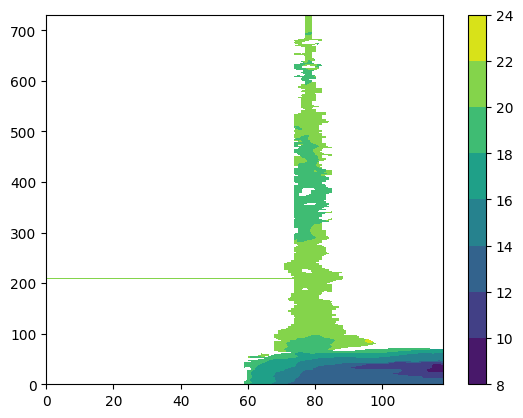

: 

In [ ]:
import matplotlib.pyplot as plt

plt.contourf(ds['temp'][0,0,:])
plt.colorbar()

The dataset can be accessed directly with xarray using kerchunk's HTTPFileSystem. This creates a virtual filesystem that maps the zarr chunks and metadata to HTTP endpoints running on XREDS.

This allows us to facade where the data is stored from how it's accessed which allows more flexibility for data storage options.

In [2]:
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

# We can access our API using fsspec's HTTPFileSystem
fs = HTTPFileSystem()

# The http mapper gives us a dict-like interface to the API
http_map = fs.get_mapper("http://nextgen-dev.ioos.us/xreds/datasets/dbofs/zarr")

ds = xr.open_zarr(http_map, consolidated=True)
ds

<xarray.Dataset>
Dimensions:        (ocean_time: 805, tracer: 2, s_rho: 10, s_w: 11,
                    boundary: 4, eta_rho: 732, xi_rho: 119, eta_psi: 731,
                    xi_psi: 118, eta_u: 732, xi_u: 118, eta_v: 731, xi_v: 119)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(731, 118), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(732, 119), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(732, 118), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(731, 119), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2023-05-27T14:00:00 ... 2023-0...
  * s_rho          (s_rho) float64 -0.95 -0.85 -0.75 -0.65 ... -0.25 -0.15 -0.05
  * s_w            (s_w) float64 -1.0 -0.9 -0.8 -0.7 -0.6 ... -0.3 -0.2 -0.1 0.0
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_psi,
                                xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/78)
    Akk_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akp_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_r           (ocean_time, s_rho) float64 dask.array<chunksize=(1, 10), meta=np.ndarray>
    Cs_w           (ocean_time, s_w) float64 dask.array<chunksize=(1, 11), meta=np.ndarray>
    ...             ...
    theta_s        (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    u              (ocean_time, s_rho, eta_u, xi_u) float32 dask.array<chunksize=(1, 10, 732, 118), meta=np.ndarray>
    v              (ocean_time, s_rho, eta_v, xi_v) float32 dask.array<chunksize=(1, 10, 731, 119), meta=np.ndarray>
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 6, 732, 119), meta=np.ndarray>
    xl             (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    zeta           (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 732, 119), meta=np.ndarray>
Attributes: (12/33)
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...
    Conventions:       CF-1.4, SGRID-0.3
    NLM_LBC:           \nEDGE:  WEST   SOUTH  EAST   NORTH  \nzeta:  Cha    C...
    NLM_TADV:          \nADVECTION:   HORIZONTAL   VERTICAL     \ntemp:      ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    bry_file_01:       nos.dbofs.obc.20230528.t00z.nc
    ...                ...
    svn_url:           
    tide_file:         nos.dbofs.roms.tides.nc
    tiling:            008x016
    title:             dbofs forecast RUN in operational mode
    type:              ROMS/TOMS history file
    var_info:          varinfo.yaml

We can plot the data in its native grid structure using datashader. 

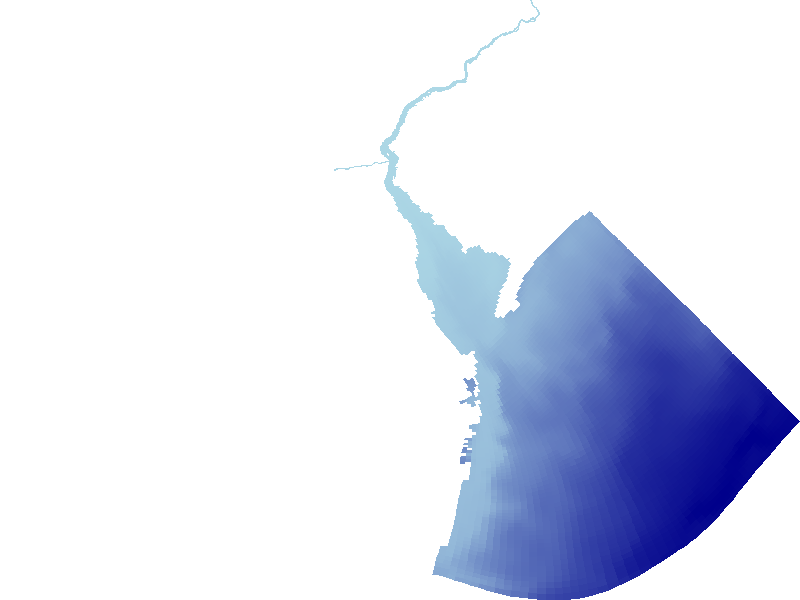

In [3]:
import datashader as dsh
import datashader.transfer_functions as tf

# ds.temp.isel(ocean_time=0, s_rho=0).plot(x='lon_rho', y="lat_rho")
sst = ds.salt.isel(ocean_time=1, s_rho=0)

cvs = dsh.Canvas(plot_width=800, plot_height=600)
tf.shade(cvs.quadmesh(sst, x='lon_rho', y='lat_rho'))